<a href="https://colab.research.google.com/github/Javcm/Deep-Learning/blob/main/Transfer_Learning_animals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Tarea 3<center>
# <center>Para entregar el 29 de octubre<center>

## 1. ¿Qué es Batch normalization? Escribe un reporte breve explicando qué es, para qué sirve y cómo se realiza. Incluye ejemplos ilustrativos (sencillos).

### <font color=green>Tu respuesta aquí</font>

## 2. Dados los siguientes parámetros para algún eje (canal) de un tensor:

### - $i$: tamaño de los datos de entrada (cuadradas: $i_1=i_2=i$) 
### - $k$: tamaño de un kernel de convolución cuadrado
### - $s$: tamaño de stride (igual en ambas direcciones)
### - $p$: zero padding (igual en ambas direcciones)

## obtén una expresión para calcular:
## a) el tamaño de salida del mapeo luego de realizar una convolución.
## b) el tamaño de salida del proceso de pooling

### <font color=green>Tu respuesta aquí</font>

## 3. En el archivo `wildlife.tar.gz`, se encuentra un conjunto pequeño de imágenes de distintos animales salvajes, con la siguiente distribución;

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from google.colab import drive 
drive.mount('/content/gdrive')

#%matplotlib inline
warnings.filterwarnings("ignore")
# observa cual es mi directorio...
#os.chdir('/home/victor/cursos/optativa2020/')

# ya esta descomprimido, y guardado con esta estructura de directorio
data_set = '/content/gdrive/My Drive/T3 DL/wildlife'

labels = os.listdir(data_set)
print("Categorias:", len(labels))

total = 0
for lb in os.scandir(data_set):
    print('folder {}: imagenes {}'.format(lb.name, len(os.listdir(lb))))
    total += len(os.listdir(lb))
print('Total de imagenes:', total)


Mounted at /content/gdrive
Categorias: 20
folder coyote: imagenes 736
folder columbian_black-tailed_deer: imagenes 735
folder black_bear: imagenes 718
folder deer: imagenes 764
folder cougar: imagenes 680
folder gray_fox: imagenes 668
folder canada_lynx: imagenes 717
folder elk: imagenes 660
folder bobcat: imagenes 696
folder bald_eagle: imagenes 748
folder gray_wolf: imagenes 730
folder mountain_beaver: imagenes 577
folder nutria: imagenes 701
folder raccoon: imagenes 728
folder ringtail: imagenes 588
folder seals: imagenes 698
folder virginia_opossum: imagenes 728
folder red_fox: imagenes 759
folder raven: imagenes 656
folder sea_lions: imagenes 726
Total de imagenes: 14013


#### De las 20 etiquetas, nos enfocaremos en 5 de ellas: `deer`, `red fox`, `bald eagle`, `gray wolf` y `coyote`. Para facilitarte el ejercicio, he preparado dos archivos con los datos de las imágenes de éstas 5 categorias. En  `imagenes_info_train.csv` e `imagenes_info_test.csv`, se encuentra la información de las imágenes de entrenamiento y prueba, respectívamente. En cada uno, encontrarás el nombre de la imagen y su categoría correspondiente. Una muestra de las imágenes de entrenamiento es la siguiente.

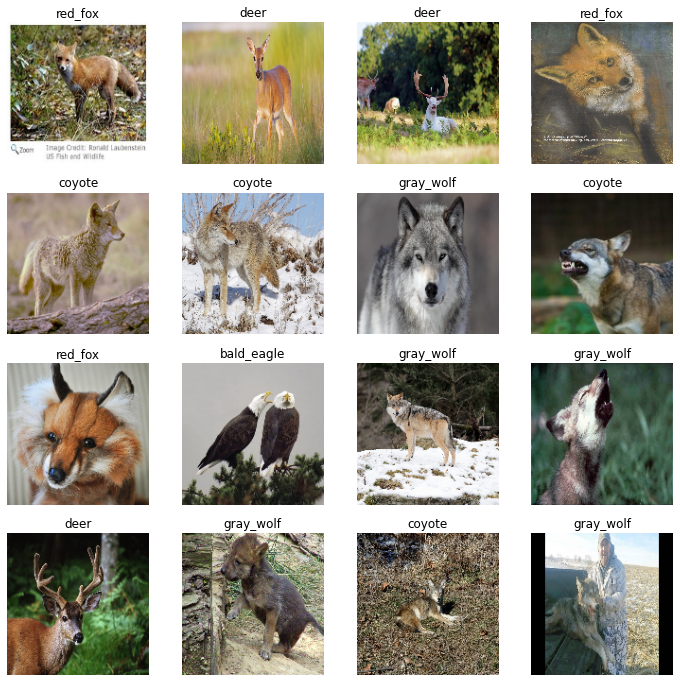

In [ ]:
def plot_sample(imgs_set, labels_set, img_size=(12,12), columns=4, rows=4, random=False):
    """
    Plot a sample of images
    """
    
    fig=plt.figure(figsize=img_size)
    
    for i in range(1, columns*rows + 1):
        
        if random:
            img_x = np.random.randint(0, len(imgs_set))
        else:
            img_x = i-1

        img = imgs_set[img_x]
        ax = fig.add_subplot(rows, columns, i)
        ax.set_title(str(labels_set[img_x]))
        plt.axis('off')
        im = cv2.imread(img)
        im_resized = cv2.resize(im, (150, 150), interpolation=cv2.INTER_LINEAR)
        plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

traindf=pd.read_csv('/content/gdrive/My Drive/T3 DL/imagenes_info_train.csv',dtype=str)
testdf=pd.read_csv('/content/gdrive/My Drive/T3 DL/imagenes_info_test.csv',dtype=str)

## grafica algunas imagenes de prueba
plot_sample(traindf.iloc[:,0],traindf.iloc[:,1],random=True)
   

#### en la siguiente celda, verás la implementación y resultados de un modelo 'simple'

In [ ]:
# data generators
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
import time

minibatch_size = 20
n_classes = 5
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)

# funcion para verificar el tiempo transcurrido
def elapsed(start):
    # Returns elapsed time in hh:mm:ss format from start time in unix format
    elapsed = time.time()-start
    return time.strftime("%H:%M:%S", time.gmtime(elapsed))

train_generator=datagen.flow_from_dataframe(
        dataframe=traindf,
        x_col="filename",
        y_col="label",
        subset="training",
        batch_size=minibatch_size,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(150,150))

valid_generator=datagen.flow_from_dataframe(
        dataframe=traindf,
        x_col="filename",
        y_col="label",
        subset="validation",
        batch_size=minibatch_size,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(150,150))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=testdf,
    x_col="filename",
    y_col='label',
    batch_size=minibatch_size,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=(150,150))

Found 2536 validated image filenames belonging to 5 classes.
Found 634 validated image filenames belonging to 5 classes.
Found 560 validated image filenames belonging to 5 classes.


In [ ]:
# un modelo 'simple'
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu')) # CHECAR LAS UNIDADES!!!!!
model.add(layers.Dense(n_classes, activation='softmax'))
model.summary()


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
plot_model(model,show_shapes=True)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_282 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_283 (Conv2D)          (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_284 (Conv2D)          (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_285 (Conv2D)          (None, 15, 15, 128)      

NameError: ignored

In [ ]:
start = time.time()
history = model.fit(
      train_generator,
      validation_data = valid_generator,
      steps_per_epoch = 100, #int(len(traindf) / minibatch_size),
      validation_steps= 30, #int(int(len(traindf)*.2)/minibatch_size),
      initial_epoch = 0,
      epochs=50,
      verbose = 1)
print('\nElapsed time: {}'.format(elapsed(start)))

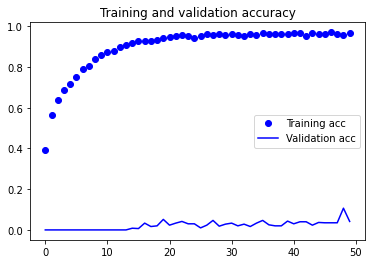

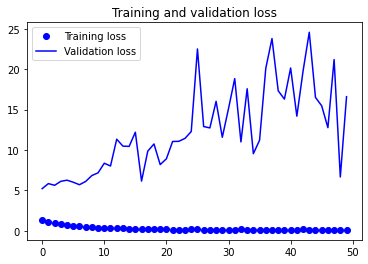

In [ ]:
model.save('/content/gdrive/My Drive/T3 DL/model.h5')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)

28/28 [==============================] - 260s 9s/step - loss: 4.2017 - accuracy: 0.7446
test acc: 0.7446428537368774


### a) Toma el resultado anterior como tu Baseline. El objetivo es superar ése baseline. Para esto, aplica TODO lo que has aprendido hasta ahora, buscando un modelo que tenga un buen error de generalización y una buena precisión (al menos, mejor que tu baseline). Para esto, usa Transfer Learning con algún modelo pre-entrenado de Keras (VGG16, VGG19, Xception, InceptionV3, ResNet50, MobileNet, etc), así como los métodos de regularización que conoces.
  ### Explica todos los pasos y detalles de tu arquitectura.
  ### EL MODELO GANADOR, TENDRÁ UNA BUENA RECOMPENSA

In [ ]:
in_shape = (299, 299, 3)

from keras.applications.inception_v3 import InceptionV3
model_incV3 = InceptionV3(weights="imagenet",
    include_top=True)

from keras.applications import VGG19
model_VGG19 = VGG19(
    include_top=True,weights="imagenet")

from keras.applications import VGG16
model_VGG16 = VGG16(weights='imagenet',
    include_top=False)

from keras.applications import Xception
model_Xcept = Xception(weights='imagenet',
    include_top=False)

from keras.applications import ResNet50
model_ResNet50 = ResNet50(weights='imagenet',
    include_top=False)

from keras.applications import InceptionResNetV2
model_InceptionResNetV2 = InceptionResNetV2(weights='imagenet',
    include_top=False)

models = [model_incV3,model_VGG19,model_VGG16,model_Xcept,model_ResNet50,model_InceptionResNetV2]

219062272/219055592 [==============================] - 3s 0us/step


In [ ]:
# data generators
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
import time

minibatch_size = 20
n_classes = 5
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)

# funcion para verificar el tiempo transcurrido
def elapsed(start):
    # Returns elapsed time in hh:mm:ss format from start time in unix format
    elapsed = time.time()-start
    return time.strftime("%H:%M:%S", time.gmtime(elapsed))

train_generator=datagen.flow_from_dataframe(
        dataframe=traindf,
        x_col="filename",
        y_col="label",
        subset="training",
        batch_size=minibatch_size,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(150,150))

valid_generator=datagen.flow_from_dataframe(
        dataframe=traindf,
        x_col="filename",
        y_col="label",
        subset="validation",
        batch_size=minibatch_size,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(150,150))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=testdf,
    x_col="filename",
    y_col='label',
    batch_size=minibatch_size,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=(150,150))

def extract_features(generator, sample_count,model):
  features = np.zeros(shape=(sample_count, 3, 3, 2048))
  #features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count,5))
  #labels = np.zeros(shape=(sample_count))
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = model.predict(inputs_batch)
    features[i * minibatch_size : (i + 1) * minibatch_size] = features_batch
    labels[i * minibatch_size : (i + 1) * minibatch_size] = labels_batch
    i += 1
    if i * minibatch_size >= sample_count:
      break
    return features, labels

def train_model(train_generator,valid_generator,test_generator,model):
  from keras import models
  from keras import layers
  from keras import optimizers
  import matplotlib.pyplot as plt
  train_features, train_labels = extract_features(train_generator, 2536,model)
  validation_features, validation_labels = extract_features(valid_generator, 634,model)
  test_features, test_labels = extract_features(test_generator, 560,model)

  # #Reshaping the stuff
  train_features = np.reshape(train_features, (np.shape(train_features)[0], np.shape(train_features)[1] * np.shape(train_features)[2] * np.shape(train_features)[3]))
  validation_features = np.reshape(validation_features, (np.shape(validation_features)[0], np.shape(validation_features)[1] * np.shape(validation_features)[2] * np.shape(validation_features)[3]))
  test_features = np.reshape(test_features, (np.shape(test_features)[0], np.shape(test_features)[1] * np.shape(test_features)[2] * np.shape(test_features)[3]))

  model = models.Sequential()
  model.add(layers.Dense(256, activation='relu', input_dim=np.shape(train_features)[1]))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(5, activation='sigmoid'))

  model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                loss='categorical_crossentropy',metrics=['acc'])


  history = model.fit(train_features, train_labels,
                      epochs=30,batch_size=20,
                      validation_data=(validation_features, validation_labels))


  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

  return history

Found 2536 validated image filenames belonging to 5 classes.
Found 634 validated image filenames belonging to 5 classes.
Found 560 validated image filenames belonging to 5 classes.


In [ ]:
# data generators
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
import time

minibatch_size = 20
n_classes = 5
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)

# funcion para verificar el tiempo transcurrido
def elapsed(start):
    # Returns elapsed time in hh:mm:ss format from start time in unix format
    elapsed = time.time()-start
    return time.strftime("%H:%M:%S", time.gmtime(elapsed))

train_generator=datagen.flow_from_dataframe(
        dataframe=traindf,
        x_col="filename",
        y_col="label",
        subset="training",
        batch_size=minibatch_size,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(150,150))

valid_generator=datagen.flow_from_dataframe(
        dataframe=traindf,
        x_col="filename",
        y_col="label",
        subset="validation",
        batch_size=minibatch_size,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(150,150))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=testdf,
    x_col="filename",
    y_col='label',
    batch_size=minibatch_size,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=(150,150))

def extract_features(generator, sample_count,model):
  features = np.zeros(shape=(sample_count, 3, 3, 2048))
  #features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count,5))
  #labels = np.zeros(shape=(sample_count))
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = model.predict(inputs_batch)
    features[i * minibatch_size : (i + 1) * minibatch_size] = features_batch
    labels[i * minibatch_size : (i + 1) * minibatch_size] = labels_batch
    i += 1
    if i * minibatch_size >= sample_count:
      break
    return features, labels



train_features, train_labels = extract_features(train_generator, 2536)
validation_features, validation_labels = extract_features(valid_generator, 634)
test_features, test_labels = extract_features(test_generator, 560)

# #Verificando que las dimensiones sean correctas
print(np.shape(train_labels),np.shape(train_features))
print(np.shape(validation_labels),np.shape(validation_features))
print(np.shape(test_labels),np.shape(test_features))

# #Reshaping the stuff
train_features = np.reshape(train_features, (np.shape(train_features)[0], np.shape(train_features)[1] * np.shape(train_features)[2] * np.shape(train_features)[3]))
validation_features = np.reshape(validation_features, (np.shape(validation_features)[0], np.shape(validation_features)[1] * np.shape(validation_features)[2] * np.shape(validation_features)[3]))
test_features = np.reshape(test_features, (np.shape(test_features)[0], np.shape(test_features)[1] * np.shape(test_features)[2] * np.shape(test_features)[3]))

# #Verificando que las dimensiones sean correctas
print("After flattening:")
print(np.shape(train_labels),np.shape(train_features))
print(np.shape(validation_labels),np.shape(validation_features))
print(np.shape(test_labels),np.shape(test_features))

Found 2536 validated image filenames belonging to 5 classes.
Found 634 validated image filenames belonging to 5 classes.
Found 560 validated image filenames belonging to 5 classes.
(2536, 5) (2536, 3, 3, 2048)
(634, 5) (634, 3, 3, 2048)
(560, 5) (560, 3, 3, 2048)
After flattening:
(2536, 5) (2536, 18432)
(634, 5) (634, 18432)
(560, 5) (560, 18432)


In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=np.shape(train_features)[1]))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',metrics=['acc'])


history = model.fit(train_features, train_labels,
                    epochs=30,batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
127/127 [==============================] - 5s 43ms/step - loss: 0.0110 - acc: 0.4282 - val_loss: 0.1897 - val_acc: 0.0000e+00
Epoch 2/30
127/127 [==============================] - 5s 40ms/step - loss: 0.0104 - acc: 0.0371 - val_loss: 0.2344 - val_acc: 0.9685
Epoch 3/30
127/127 [==============================] - 5s 40ms/step - loss: 0.0096 - acc: 0.1711 - val_loss: 0.2310 - val_acc: 0.0000e+00
Epoch 4/30
127/127 [==============================] - 5s 41ms/step - loss: 0.0109 - acc: 0.0150 - val_loss: 0.2136 - val_acc: 0.0000e+00
Epoch 5/30
127/127 [==============================] - 5s 42ms/step - loss: 0.0060 - acc: 0.0138 - val_loss: 0.2911 - val_acc: 0.0000e+00
Epoch 6/30
127/127 [==============================] - 5s 40ms/step - loss: 0.0024 - acc: 0.0083 - val_loss: 0.2474 - val_acc: 0.0000e+00
Epoch 7/30
127/127 [==============================] - 8s 60ms/step - loss: 0.0021 - acc: 0.0079 - val_loss: 0.2903 - val_acc: 0.0000e+00
Epoch 8/30
127/127 [=========================

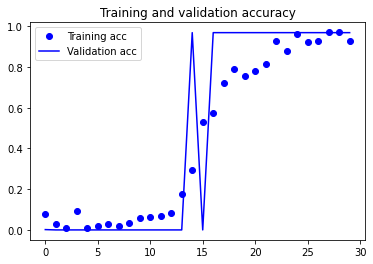

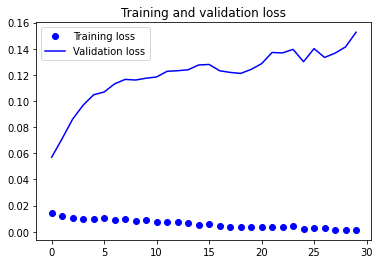

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)

NameError: ignored

### b) Usando las capas de convolución de tu modelo, obtén las representaciones (embeddings) de las imágenes de prueba, es decir, al salir de la última capa de convolución. Obtén una visualización de éstas representaciones con algún método de reducción de dimensión (PCA, tSNE). ¿Encuentras patrones interesantes?

In [ ]:
# TU CODIGO Y RESULTADOS AQUI